# Libraries and Functions

In [1]:
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
def weighted_average(group):
    # Calculate the sum of total_examples for the current group
    total_examples_sum = group['total_examples'].sum()
    
    # Initialize the dictionary with keys that will not undergo weighted average calculation
    weighted_avg = {
        'total_examples': total_examples_sum,
        'dataset': 'Overall',  # Set the dataset name
        'round': group['round'].iloc[0]  # The round number is the same for all entries in the group
    }
    
    # Iterate over columns to calculate weighted average for applicable columns
    for column in group.columns:
        if column not in ['total_examples', 'dataset', 'round']:
            weighted_avg[column] = (group[column] * group['total_examples']).sum() / total_examples_sum
    
    return pd.Series(weighted_avg)

In [17]:
def history_to_df_melted(base_path, history_key, metric_type):
    # Read history from pickle file
    with open(str(Path(base_path) / "results.pkl"), 'rb') as file:
        history = pickle.load(file)['history']
        history = history.__dict__[history_key] # metrics_distributed or metrics_distributed_fit

    # Convert dictionary to DataFrame
    results = []
    for key, value in history.items():
        dataset = key
        for rnd, metrics in value:
            metrics['dataset'] = dataset.upper()
            metrics['round'] = rnd
            results.append(metrics)
    df = pd.DataFrame(results)
    
    try:
        # Calculate weighted averages
        weighted_averages_df = df.groupby('round').apply(weighted_average).reset_index(drop=True)
        df = pd.concat([df, weighted_averages_df])
    except KeyError:
        return None
        
    # Selecting columns based on user input
    value_vars = df.columns[[metric_type in col for col in df.columns]]

    # Melting the DataFrame
    df_melted = df.melt(id_vars=['dataset', 'round'], value_vars=value_vars, 
                        var_name='type', value_name=metric_type)
    
    # Split the column into three new columns
    df_melted[['subset', 'metric', 'type']] = df_melted['type'].str.split('_', expand=True)
    
    return df_melted

# Single Run

## Input

In [4]:
# User input
base_path = "outputs/2024-04-23/02-05-35"
metric_type = 'accuracy'  # loss or accuracy

## Table Metrics

In [19]:
def history_to_df_summary(base_path, metric_type):
    df_melted_fit = history_to_df_melted(base_path, 'metrics_distributed_fit', metric_type)
    
    if df_melted_fit is None:
        return None
    
    df_fit = df_melted_fit.groupby(['dataset', 'subset', 'type']).last().unstack(level=['subset', 'type'])[metric_type]

    df_melted_test = history_to_df_melted(base_path, 'metrics_distributed', metric_type)
    df_test = df_melted_test.groupby(['dataset', 'subset', 'type']).last().unstack(level=['subset', 'type'])[metric_type]

    df_concat = pd.concat([df_fit, df_test], axis=1)

    df_concat.index = pd.CategoricalIndex(df_concat.index, categories=['DEAP', 'SEED', 'DREAMER', 'Overall'], ordered=True)
    df_concat.sort_index(inplace=True)
    
    return df_concat

In [6]:
df_summary = history_to_df_summary(base_path, metric_type)
df_summary

2024-05-01 17:57:26.445817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 17:57:26.464915: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 17:57:26.555472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 17:57:26.555522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 17:57:26.572032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

subset       train                   val                  test           
type        client     server     client     server     client     server
dataset                                                                  
DEAP     99.988153  96.254442  99.988153  96.951841  97.951313  54.551448
SEED     94.837304  97.819688  94.837304  98.295835  90.169161  78.229281
DREAMER  85.080632  61.753289  85.080632  61.917434  81.499093  60.952771
Overall  93.159545  85.697903  93.159545  86.136640  89.598989  65.835665

## Fit Accuracy and Loss Graph

In [7]:
df_melted = history_to_df_melted(base_path, 'metrics_distributed_fit', metric_type)
df_melted

,dataset,round,type,accuracy,subset,metric
0,DREAMER,1,server,60.932563,train,accuracy
1,DREAMER,2,server,60.918847,train,accuracy
2,DREAMER,3,server,60.921590,train,accuracy
3,DREAMER,4,server,61.091222,train,accuracy
4,DREAMER,5,server,61.339040,train,accuracy
...,...,...,...,...,...,...
155,Overall,6,client,93.159545,val,accuracy
156,Overall,7,client,93.159545,val,accuracy
157,Overall,8,client,93.159545,val,accuracy
158,Overall,9,client,93.159545,val,accuracy


/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


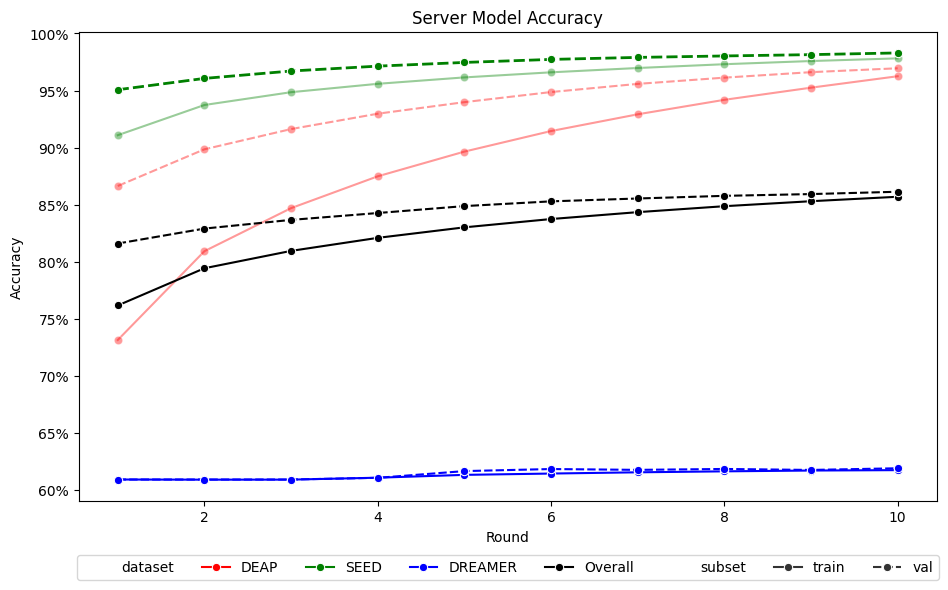

/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


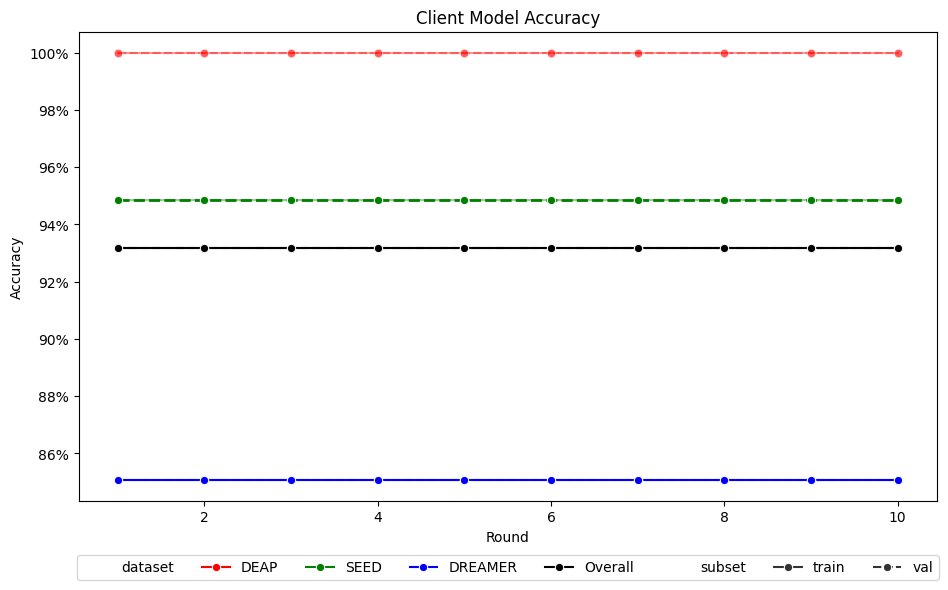

In [8]:
# Data preparation
df_melted = history_to_df_melted(base_path, 'metrics_distributed_fit', metric_type)

# Visualization
hue_order = ['DEAP', 'SEED', 'DREAMER', 'Overall']
hue_color = ['red', 'green', 'blue', 'black']

for fit_type in ['server', 'client']:
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=df_melted[df_melted['type'] == fit_type], 
                      x='round', y=metric_type, 
                      hue='dataset', hue_order=hue_order, palette=hue_color, 
                      style='subset', marker='o')

    # Customizing line styles immediately after plotting
    lines = ax.get_lines()
    for line in lines:
        label = line.get_label()
        if label in ['_child0', '_child2', '_child4']:
            line.set_alpha(0.4)  # Make these lines a bit transparent
        elif label == '_child6':
            line.set_linewidth(2)  # Make the line bolder

    plt.title(f'{fit_type.capitalize()} Model {metric_type.capitalize()}')
    plt.xlabel('Round')
    plt.ylabel(metric_type.capitalize())
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=8)
    if metric_type == 'accuracy':
        plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100, decimals=0))
    
    plt.tight_layout()
    plt.show()

## Test Accuracy and Loss Graph

/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


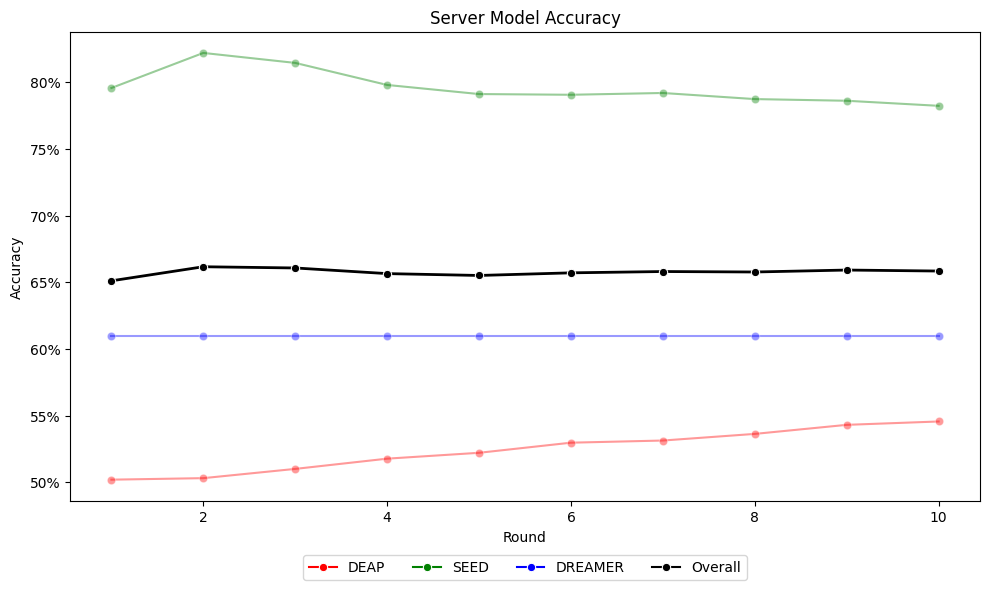

/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


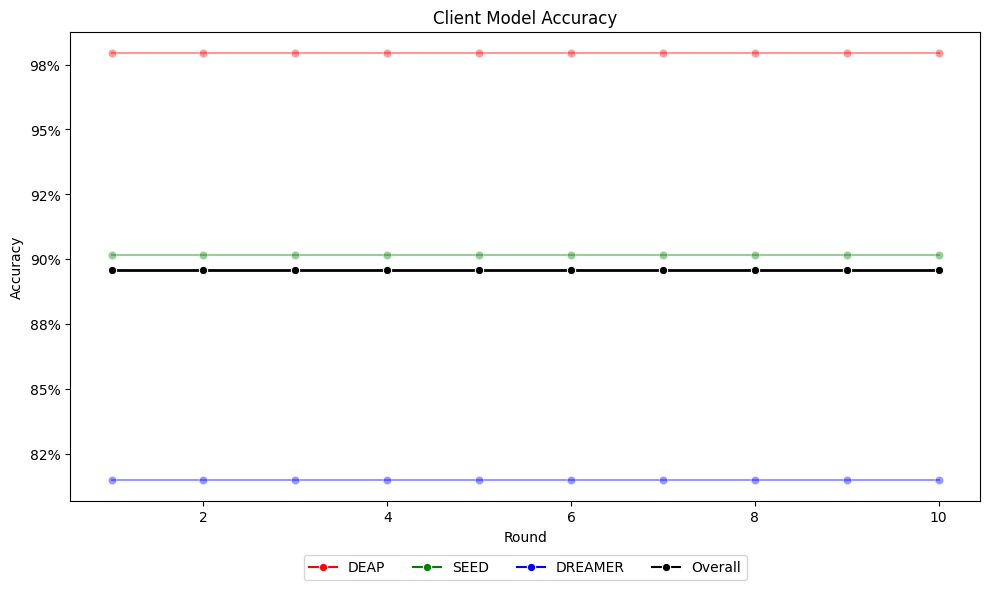

In [9]:
# Data preparation
df_melted = history_to_df_melted(base_path, 'metrics_distributed', metric_type)

# Visualization
hue_order = ['DEAP', 'SEED', 'DREAMER', 'Overall']
hue_color = ['red', 'green', 'blue', 'black']

for model_type in ['server', 'client']:
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=df_melted[df_melted['type'] == model_type], 
                      x='round', y=metric_type, 
                      hue='dataset', hue_order=hue_order, palette=hue_color, 
                      marker='o')

    # Customizing line styles immediately after plotting
    lines = ax.get_lines()
    for line in lines:
        label = line.get_label()
        if label in ['_child0', '_child2', '_child4']:
            line.set_alpha(0.4)  # Make these lines a bit transparent
        elif label == '_child6':
            line.set_linewidth(2)  # Make the line bolder

    plt.title(f'{model_type.capitalize()} Model {metric_type.capitalize()}')
    plt.xlabel('Round')
    plt.ylabel(metric_type.capitalize())
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    if metric_type == 'accuracy':
        plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100, decimals=0))
    
    plt.tight_layout()
    plt.show()

# Multirun

In [10]:
import yaml
import os

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
        return data

In [21]:
def read_multirun(multirun_path, metric_type):
    all_summary = []
    for run_dir in sorted(os.listdir(multirun_path)):
        
        config_path = os.path.join(multirun_path, run_dir, '.hydra', 'overrides.yaml')
        
        if os.path.exists(config_path):
            config_data = read_yaml(config_path)
            config_dict = {item.split('=')[0]: float(item.split('=')[1]) if item.split('=')[1].replace('.', '', 1).isdigit() else item.split('=')[1] for item in config_data}

            base_path = os.path.join(multirun_path, run_dir)
            results_path = os.path.join(base_path, 'results.pkl')
            if os.path.exists(results_path):
                df = history_to_df_summary(base_path, metric_type)
                
                if df is None:
                    continue
                
                for k, v in config_dict.items():
                    df[k] = v
                
                config_dict_keys = list(config_dict.keys())
                df.set_index(config_dict_keys, append=True, inplace=True)
                df = df.reorder_levels(config_dict_keys + ['dataset'])
                
                all_summary.append(df)
                
    return pd.concat(all_summary).sort_index()

In [12]:
# Offline vs Online distillation
# On the test set, the server model performs better in online setting than in offline setting with various configurations

multirun_path = "multirun/2024-04-23/17-24-46/"
metric_type = 'accuracy'

df = read_multirun(multirun_path, metric_type)
df = df['test'].reset_index()
df[df['dataset'] == 'Overall'].pivot(
    index='config_fit.mode',
    columns=['config_fit.temperature', 'config_fit.alpha']
)[['server']]

type                       server                                              \
config_fit.temperature       1.0                   5.0                   10.0   
config_fit.alpha              0.0        0.5        0.0        0.5        0.0   
config_fit.mode                                                                 
offline                 61.076466  54.525998  55.309649  64.324237  63.203924   
online                  65.436027  66.683713  65.804414  67.031739  65.927052   

type                               
config_fit.temperature             
config_fit.alpha              0.5  
config_fit.mode                    
offline                 64.815262  
online                  66.674243

In [13]:
# this is online distillation with alpha = 0 
# client performances are the same for the same seed
# but, server performances are different because different temperature 
multirun_path = "multirun/2024-04-28/02-12-35/"
metric_type = 'accuracy'

df = read_multirun(multirun_path, metric_type)
df = df['test'].reset_index()
df[df['dataset'] == 'Overall']

type,seed,config_fit.temperature,dataset,client,server
3,1.0,1.0,Overall,91.913008,62.690171
7,1.0,5.0,Overall,91.913008,63.448727
11,1.0,10.0,Overall,91.913008,63.456303
15,2.0,1.0,Overall,91.844349,64.274519
19,2.0,5.0,Overall,91.844349,64.794428
23,2.0,10.0,Overall,91.844349,64.301509


In [14]:
# this is offline distillation with alpha = 0
# client and server performances are the same for the same seed
multirun_path = "multirun/2024-04-29/01-23-18/"
metric_type = 'accuracy'

df = read_multirun(multirun_path, metric_type)
df = df['test'].reset_index()
df[df['dataset'] == 'Overall']

type,seed,config_fit.temperature,dataset,client,server
3,1.0,1.0,Overall,91.913008,48.762021
7,1.0,5.0,Overall,91.913008,48.762021
11,1.0,10.0,Overall,91.913008,48.762021
15,2.0,1.0,Overall,91.844349,48.704727
19,2.0,5.0,Overall,91.844349,48.704727
23,2.0,10.0,Overall,91.844349,48.704727


In [23]:
pd.set_option('display.max_rows', None)
multirun_path = "multirun/2024-04-30/19-34-59/"
metric_type = 'accuracy'

df = read_multirun(multirun_path, metric_type)
df

subset                                  train                   val  \
type                                   client     server     client   
num_rounds seed model_type dataset                                    
25.0       1.0  cbamfm     DEAP     99.243369  48.000000  99.243369   
                           SEED     93.206919  49.310500  93.206919   
                           DREAMER  83.768386  60.894613  83.768386   
                           Overall  93.206919  49.310500  93.206919   
                ccnn       DEAP     99.243369  47.939737  99.243369   
                           SEED     93.206919  49.221127  93.206919   
                           DREAMER  83.768386  43.011033  83.768386   
                           Overall  91.886541  46.843237  91.886541   
                fbccnn     DEAP     99.243369  47.263456  99.243369   
                           SEED     93.206919  51.320814  93.206919   
                           DREAMER  83.768386  39.098985  83.768386   
                           Overall  91.886541  46.199854  91.886541   
                simplevit  DEAP     99.243369  49.998455  99.243369   
                           SEED     93.206919  48.913837  93.206919   
                           DREAMER  83.768386  39.098985  83.768386   
                           Overall  91.886541  46.049071  91.886541   
                vit        DEAP     99.243369  43.388102  99.243369   
                           SEED     93.206919  48.913837  93.206919   
                           DREAMER  83.768386  39.098985  83.768386   
                           Overall  93.206919  48.913837  93.206919   
           2.0  cbamfm     DEAP     99.260881  47.795004  99.260881   
                           SEED     93.184480  49.349671  93.184480   
                           DREAMER  83.771587  60.803625  83.771587   
                           Overall  83.771587  60.803625  83.771587   
                ccnn       DEAP     99.260881  47.826938  99.260881   
                           SEED     93.184480  49.210859  93.184480   
                           DREAMER  83.771587  43.084647  83.771587   
                           Overall  99.260881  47.826938  99.260881   
                fbccnn     DEAP     99.260881  47.251610  99.260881   
                           SEED     93.184480  51.305221  93.184480   
                           DREAMER  83.771587  39.191803  83.771587   
                           Overall  99.260881  47.251610  99.260881   
                simplevit  DEAP     99.260881  49.822817  99.260881   
                           SEED     93.184480  48.896723  93.184480   
                           DREAMER  83.771587  39.191803  83.771587   
                           Overall  99.260881  49.822817  99.260881   
                vit        DEAP     99.260881  43.407159  99.260881   
                           SEED     93.184480  48.896723  93.184480   
                           DREAMER  83.771587  39.191803  83.771587   
                           Overall  99.260881  43.407159  99.260881   
           3.0  cbamfm     DEAP     99.242853  47.917074  99.242853   
                           SEED     93.109559  49.274751  93.109559   
                           DREAMER  83.768844  60.884554  83.768844   
                           Overall  93.109559  49.274751  93.109559   
                ccnn       DEAP     99.242853  47.976822  99.242853   
                           SEED     93.109559  49.157615  93.109559   
                           DREAMER  83.768844  42.865634  83.768844   
                           Overall  93.109559  49.157615  93.109559   
                fbccnn     DEAP     99.242853  47.244914  99.242853   
                           SEED     93.109559  51.342111  93.109559   
                           DREAMER  83.768844  39.109044  83.768844   
                           Overall  93.109559  51.342111  93.109559   
                simplevit  DEAP     99.242853  49.818697  99.242853   
                        